In [17]:
!pip install pandas
!pip install numpy
!pip install sqlalchemy
!pip install matplotlib


In [18]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


DataLoader Class

In [19]:
class DataLoader:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None

    def load_data(self):
        try:
            self.data = pd.read_csv(self.file_path)
            print("Data loaded successfully!")
        except FileNotFoundError:
            raise Exception(f"File not found: {self.file_path}")
        except Exception as e:
            raise Exception(f"An error occurred while loading data: {e}")

    def clean_data(self):
        if self.data is not None:
            self.data.drop_duplicates(inplace=True)
            self.data.dropna(inplace=True)
            self.data = self.data[self.data['sensor_value'] >= 0]
            print("Data cleaned successfully!")
        else:
            raise Exception("No data loaded to clean.")

    def get_cleaned_data(self):
        return self.data


DatabaseHandler Class

In [20]:
class DatabaseHandler:
    def __init__(self, db_name="iot_sensor_data.db"):
        self.conn = sqlite3.connect(db_name)
        self.cursor = self.conn.cursor()

    def create_tables(self):
        query = """
        CREATE TABLE IF NOT EXISTS sensor_data (
            site_id TEXT,
            meter_id TEXT,
            timestamp TEXT,
            sensor_name TEXT,
            sensor_value REAL,
            status TEXT
        )
        """
        self.cursor.execute(query)
        self.conn.commit()
        print("Database tables created successfully!")

    def load_data_to_db(self, data):
        data.to_sql('sensor_data', self.conn, if_exists='replace', index=False)
        print("Data loaded into database successfully!")

    def execute_query(self, query):
        return pd.read_sql_query(query, self.conn)

    def close_connection(self):
        self.conn.close()


DataPreProcessor Class

In [21]:
class DataPreProcessor:
    @staticmethod
    def normalize_values(data, column):
        data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())
        print(f"Normalized column: {column}")
        return data

    @staticmethod
    def create_time_series(data):
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data.set_index('timestamp', inplace=True)
        print("Time-series DataFrame created.")
        return data

    @staticmethod
    def interpolate_missing(data, column):
        data[column].interpolate(method='time', inplace=True)
        print(f"Interpolated missing values for: {column}")
        return data


MetricsCalculator Class

In [22]:
class MetricsCalculator:
    @staticmethod
    def calculate_metrics(data):
        metrics = data.groupby([data.index.date, 'site_id', 'sensor_name']).agg({
            'sensor_value': ['mean', 'max', 'sum']
        })
        metrics.columns = ['average', 'maximum', 'daily_sum']
        metrics.reset_index(inplace=True)
        print("Metrics calculated successfully!")
        return metrics


GraphGenerator Class

In [23]:
class GraphGenerator:
    @staticmethod
    def generate_plot(data, output_path, column, title):
        plt.figure(figsize=(10, 6))
        data[column].plot(title=title)
        plt.savefig(os.path.join(output_path, f"{title}.png"))
        print(f"Plot saved: {title}.png")


DataReportGenerator Class

In [24]:
class DataReportGenerator:
    @staticmethod
    def export_to_csv(data, file_name):
        data.to_csv(file_name, index=False)
        print(f"Report exported to: {file_name}")


Main Workflow

Configuration

In [25]:
file_path = "./IoT_Sensor_Data.csv"
db_name = "iot_sensor_data.db"
output_folder = "./plots"
os.makedirs(output_folder, exist_ok=True)


Load and Clean Data

In [26]:
loader = DataLoader(file_path)
loader.load_data()
loader.clean_data()
cleaned_data = loader.get_cleaned_data()


Data loaded successfully!
Data cleaned successfully!


Load Data to Database

In [27]:
db_handler = DatabaseHandler(db_name)
db_handler.create_tables()
db_handler.load_data_to_db(cleaned_data)


Database tables created successfully!
Data loaded into database successfully!


Data Processing

In [28]:
preprocessor = DataPreProcessor()
normalized_data = preprocessor.normalize_values(cleaned_data.copy(), 'sensor_value')
time_series_data = preprocessor.create_time_series(normalized_data)


Normalized column: sensor_value
Time-series DataFrame created.


Metrics Calculation

In [29]:
metrics = MetricsCalculator.calculate_metrics(time_series_data)


Metrics calculated successfully!


Generate Visualization

Plot saved: Sensor Value Over Time.png


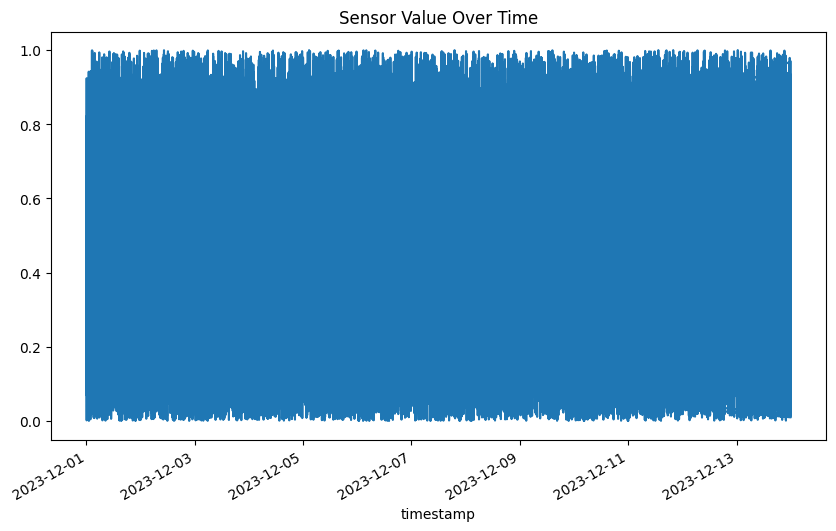

In [30]:
GraphGenerator.generate_plot(time_series_data, output_folder, 'sensor_value', "Sensor Value Over Time")


Export Report

In [31]:
DataReportGenerator.export_to_csv(metrics, "metrics_report.csv")


Report exported to: metrics_report.csv


SQL Queries : Total Power Consumption per Site, Meters with Highest Power Usage, Missing Timestamps per Meter

In [32]:
# Query 1: Total Power Consumption per Site
query_1 = """
SELECT site_id, SUM(sensor_value) AS total_power
FROM sensor_data
WHERE sensor_name = 'power_consumption'
GROUP BY site_id;
"""
result_1 = db_handler.execute_query(query_1)
print(result_1)

# Query 2: Meters with Highest Power Usage
query_2 = """
SELECT site_id, meter_id, MAX(sensor_value) AS max_power
FROM sensor_data
WHERE sensor_name = 'power_consumption'
GROUP BY site_id, meter_id
ORDER BY max_power DESC;
"""
result_2 = db_handler.execute_query(query_2)
print(result_2)

# Query 3: Missing Timestamps per Meter
query_3 = """
SELECT meter_id, timestamp
FROM (
    SELECT meter_id, timestamp,
           LEAD(timestamp) OVER (PARTITION BY meter_id ORDER BY timestamp) AS next_time
    FROM sensor_data
)
WHERE strftime('%s', next_time) - strftime('%s', timestamp) > 300;
"""
result_3 = db_handler.execute_query(query_3)
print(result_3)


  site_id  total_power
0  Site_A    225450.53
1  Site_B    220911.02
  site_id        meter_id  max_power
0  Site_B  Site_B_Meter_2     100.00
1  Site_B  Site_B_Meter_1      99.97
2  Site_A  Site_A_Meter_2      99.94
3  Site_B  Site_B_Meter_3      99.94
4  Site_A  Site_A_Meter_3      99.91
5  Site_A  Site_A_Meter_1      99.87
Empty DataFrame
Columns: [meter_id, timestamp]
Index: []


Close Database Connection

In [33]:
db_handler.close_connection()
